In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob


I have attached the current output of the nGIST run we did for the current version of the data products. The spatial binning map provide you - for every spaxel - the number of voronoi bin they belong to. The sfh weights includes two extension the "GRID" one includes the grid in age and metallicity used for the fit and the "WEIGHTS" one includes the weights associated to all the models for each of the bins. Your task is to use these info to construct a map of M/L for IC3392.

In [2]:
# # Load IC3392 raw data
# # --------- file location (edit if needed) ----------
# cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
# print("Loading:", cube_path.resolve())

# with fits.open(cube_path) as hdul:
#     # Check the file structure
#     print(hdul.info())
#     data = hdul["DATA"].data.astype(np.float32)   # (nz, ny, nx)
#     stat = hdul["STAT"].data.astype(np.float32)
#     dq   = hdul["DQ"].data.astype(np.uint8)
#     hdr  = hdul["DATA"].header
#     hdul.close()

# nz, ny, nx = data.shape
# print(f"Cube dimensions  →  nz = {nz},  ny = {ny},  nx = {nx}")
# hdr


In [3]:
# Load spatial binning map IC3392_individual.fits 
# --------- file location (edit if needed) ----------
binning_path = Path("IC3392_SPATIAL_BINNING_maps.fits")
print("Loading:", binning_path.resolve())
with fits.open(binning_path) as hdul:
    # check data structure and header
    print(hdul.info())
    binning_primary = hdul[0]
    binning_BINID   = hdul[1].data
    binning_FLUX    = hdul[2].data
    binning_SNR     = hdul[3].data
    binning_SNRBIN  = hdul[4].data
    binning_XBIN    = hdul[5].data
    binning_YBIN    = hdul[6].data
    binning_hdr     = hdul[1].header
    hdul.close()

binning_hdr


Loading: /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps.fits
Filename: IC3392_SPATIAL_BINNING_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  BINID         1 ImageHDU        26   (437, 438)   float64   
  2  FLUX          1 ImageHDU        26   (437, 438)   float64   
  3  SNR           1 ImageHDU        26   (437, 438)   float64   
  4  SNRBIN        1 ImageHDU        26   (437, 438)   float64   
  5  XBIN          1 ImageHDU        26   (437, 438)   float64   
  6  YBIN          1 ImageHDU        26   (437, 438)   float64   
None


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  437                                                  
NAXIS2  =                  438                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      216.43244136583 / Pixel coordinate of reference point            
CRPIX2  =      219.93673592818 / Pixel coordinate of reference point            
CDELT1  = -5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CDELT2  =  5.5555555555556E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

In [4]:
np.nanmin(binning_BINID), np.nanmax(binning_BINID),

(np.float64(0.0), np.float64(4076.0))

In [5]:
np.nanmin(binning_XBIN), np.nanmax(binning_XBIN),

(np.float64(-31.299767981438762), np.float64(34.50190476190504))

In [6]:
# Load SFH and weights data IC3392_sfh-weights.fits
# --------- file location (edit if needed) ----------
sfh_path = Path("IC3392_sfh-weights.fits")
print("Loading:", sfh_path.resolve())
with fits.open(sfh_path) as hdul:
    # check data structure and header
    print(hdul.info())
    weights_data = hdul[1].data
    grid_data = hdul[2].data
    weights_hdr  = hdul[1].header
    grid_hdr  = hdul[2].header

    hdul.close()
# weights_hdr
grid_hdr

Loading: /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_sfh-weights.fits
Filename: IC3392_sfh-weights.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1  WEIGHTS       1 BinTableHDU     27   4077R x 1C   [477D]   
  2  GRID          1 BinTableHDU     31   477R x 3C   [D, D, D]   


None


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                  477 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'LOGAGE  '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'METAL   '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'ALPHA   '        

In [7]:
weights_hdr

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3816 / length of dimension 1                          
NAXIS2  =                 4077 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'WEIGHTS '                                                            
TFORM1  = '477D    '                                                            
EXTNAME = 'WEIGHTS '           / extension name                                 
METHOD  = 'ppxf    '                                                            
LMIN    =                 48

In [8]:
weights_data.shape

(4077,)

In [9]:
len(weights_data[1][0])

477

In [10]:
grid_data

FITS_rec([(-1.52287875, -1.49, 0.), (-1.52287875, -1.26, 0.),
          (-1.52287875, -0.96, 0.), (-1.52287875, -0.66, 0.),
          (-1.52287875, -0.35, 0.), (-1.52287875, -0.25, 0.),
          (-1.52287875,  0.06, 0.), (-1.52287875,  0.15, 0.),
          (-1.52287875,  0.26, 0.), (-1.39794001, -1.49, 0.),
          (-1.39794001, -1.26, 0.), (-1.39794001, -0.96, 0.),
          (-1.39794001, -0.66, 0.), (-1.39794001, -0.35, 0.),
          (-1.39794001, -0.25, 0.), (-1.39794001,  0.06, 0.),
          (-1.39794001,  0.15, 0.), (-1.39794001,  0.26, 0.),
          (-1.30103   , -1.49, 0.), (-1.30103   , -1.26, 0.),
          (-1.30103   , -0.96, 0.), (-1.30103   , -0.66, 0.),
          (-1.30103   , -0.35, 0.), (-1.30103   , -0.25, 0.),
          (-1.30103   ,  0.06, 0.), (-1.30103   ,  0.15, 0.),
          (-1.30103   ,  0.26, 0.), (-1.22184875, -1.49, 0.),
          (-1.22184875, -1.26, 0.), (-1.22184875, -0.96, 0.),
          (-1.22184875, -0.66, 0.), (-1.22184875, -0.35, 0.),
        

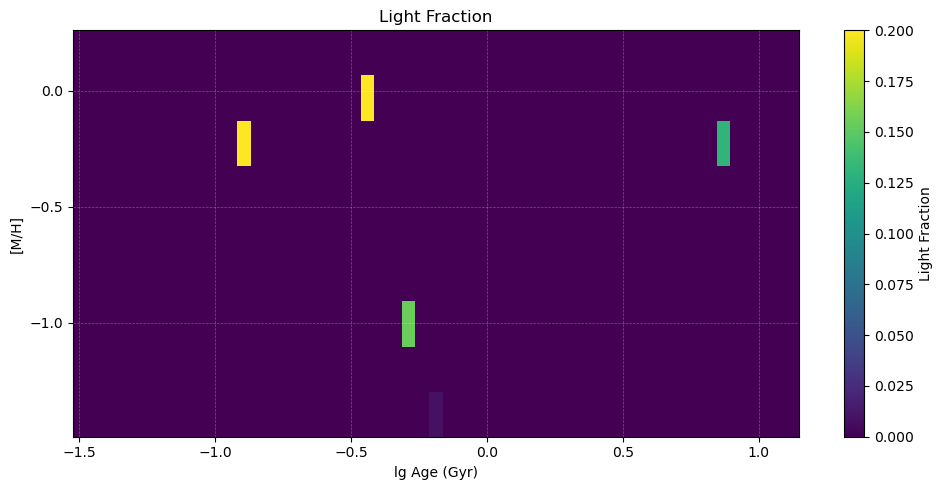

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# weights_data is your numpy array of shape (477,)
# grid_data is your FITS_rec array with LOGAGE, METAL, ALPHA values

# Extract unique log ages and metallicities from grid_data
log_ages = np.unique(grid_data['LOGAGE'])
ages = 10**log_ages
metallicities = np.unique(grid_data['METAL'])

# Create a 2D grid to store the light fraction values
light_fraction = np.zeros((len(metallicities), len(log_ages)))

# Create a dictionary mapping (LOGAGE, METAL) tuples to indices in the grid_data
grid_indices = {(row['LOGAGE'], row['METAL']): i for i, row in enumerate(grid_data)}

# Fill the grid with light fraction values
for log_age_idx, log_age in enumerate(log_ages):
    for metal_idx, metal in enumerate(metallicities):
        key = (log_age, metal)
        if key in grid_indices:
            idx = grid_indices[key]
            if idx < len(weights_data[0][0]):  # Ensure index is within bounds
                light_fraction[metal_idx, log_age_idx] = weights_data[4076][0][idx]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Determine extent based on the data ranges
x_min, x_max = min(log_ages), max(log_ages)
y_min, y_max = min(metallicities), max(metallicities)

# Plot the heatmap
im = ax.imshow(light_fraction, origin='lower', aspect='auto',
              extent=[x_min, x_max, y_min, y_max],
              vmin=0, vmax=0.2)

# Set axis labels and title
ax.set_xlabel('lg Age (Gyr)')
ax.set_ylabel('[M/H]')
ax.set_title('Light Fraction')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Light Fraction')

# Set axis ticks
x_ticks = np.arange(np.floor(x_min * 2) / 2, np.ceil(x_max * 2) / 2 + 0.1, 0.5)
ax.set_xticks(x_ticks)
ax.set_yticks([-1.5, -1.0, -0.5, 0.0])

# Add grid
ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)

ax.set_xlim(np.min(log_ages), np.max(log_ages))
ax.set_ylim(np.min(metallicities), np.max(metallicities))

plt.tight_layout()
# plt.savefig('light_fraction_heatmap.png', dpi=300)
plt.show()

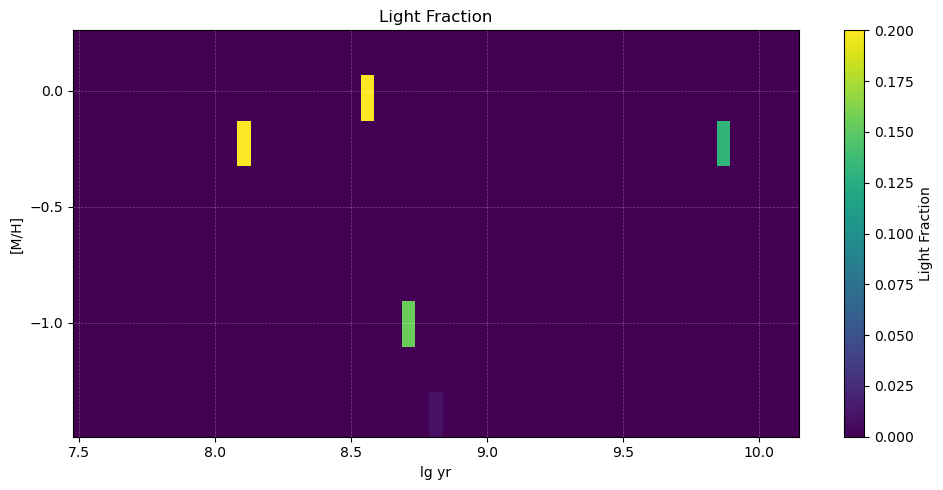

In [12]:
# … your imports and earlier code …

# Extract unique log ages (in Gyr) and metallicities
log_ages = np.unique(grid_data['LOGAGE'])
# shift by +9 to go from lg Gyr to lg yr
log_ages_shifted = log_ages + 9
metallicities = np.unique(grid_data['METAL'])

# Build light_fraction as before …
light_fraction = np.zeros((len(metallicities), len(log_ages)))
grid_indices = {(row['LOGAGE'], row['METAL']): i for i, row in enumerate(grid_data)}
for i, log_age in enumerate(log_ages):
    for j, metal in enumerate(metallicities):
        idx = grid_indices.get((log_age, metal), None)
        if idx is not None:
            light_fraction[j, i] = weights_data[4076][0][idx]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
x_min, x_max = log_ages_shifted.min(), log_ages_shifted.max()
y_min, y_max = metallicities.min(), metallicities.max()

im = ax.imshow(light_fraction, origin='lower', aspect='auto',
               extent=[x_min, x_max, y_min, y_max],
               vmin=0, vmax=0.2)

ax.set_xlabel('lg yr')           # changed label
ax.set_ylabel('[M/H]')
ax.set_title('Light Fraction')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Light Fraction')

# ticks on shifted scale
xticks = np.arange(np.floor(x_min*2)/2,
                   np.ceil(x_max*2)/2+0.1, 0.5)
ax.set_xticks(xticks)
ax.set_yticks([-1.5, -1.0, -0.5, 0.0])

ax.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
from pathlib import Path

# ---------- 2.1  Column names (from HEADER_out_phot) ----------
names = [
    'IMF','slope','MH','Age','U','B','V','R','I','J','H','K',
    'UminusV','BminusV','VminusR','VminusI','VminusJ','VminusH','VminusK',
    'ML_U','ML_B','ML_V','ML_R','ML_I','ML_J','ML_H','ML_K',
    'F439W','F555W','F675W','F814W','C439_555','C555_675','C555_814'
]

fname = Path("BaSTI+Chabrier.dat")

# ---------- 2.2  Load data, skip the two header lines ----------
tbl = np.genfromtxt(
    fname, dtype=None, encoding=None, names=names,
    comments='#', skip_header=2, autostrip=True
)                                  # :contentReference[oaicite:2]{index=2}

# ---------- 2.3  Keep only Chabrier rows ----------
mask = (tbl['IMF'] == 'Ch')
phot = tbl[mask]

print(f"Loaded {len(phot)} out of {len(tbl)} rows of data from {fname.name}")


Loaded 636 out of 636 rows of data from BaSTI+Chabrier.dat


In [14]:
# --- 3.1  Build a lookup dict keyed by (logAge, MH) rounded to 2 dec —--
key_ml = {}

for row in phot:
    age_gyr = round(row['Age'], 2)                     # e.g. 0.03 → 0.03
    mh_dex  = round(row['MH'],  2)                     # e.g. –2.27 → –2.27
    mlr     = row['ML_R']                   # keep 2 dp as requested
    key_ml[(age_gyr, mh_dex)] = mlr


In [15]:

grid = grid_data  # the FITS_rec you already loaded

# --- 4.1  Prepare new array with an extra ML_R column -------------
mlr_values = np.full(len(grid), np.nan, dtype=np.float32)

for i, (logage, mh, _) in enumerate(grid):
    age_gyr = round(10**logage, 2)   # yrs → Gyr, 2 dp
    mh_dex  = round(mh, 2)                 # already dex
    mlr_values[i] = key_ml.get((age_gyr, mh_dex), np.nan)

# --- 4.2  Build a new structured array including ML_R -------------
ml_dtype = grid.dtype.descr + [('ML_R', 'f4')]
grid_mlr  = np.empty(len(grid), dtype=ml_dtype)

for name in grid.dtype.names:
    grid_mlr[name] = grid[name]
grid_mlr['ML_R'] = mlr_values


In [16]:
# --- prerequisites already in memory ---------------------------------------
# weights_data['WEIGHTS']   -> (4077, 477)   light fractions per bin
# grid_mlr['ML_R']          -> (477,)        R-band M/L per template

# 1) convert the opaque FITS_rec into a plain ndarray
w      = weights_data['WEIGHTS'].astype(np.float32)        # (4077, 477)
ml_ssp = grid_mlr['ML_R'].astype(np.float32)               # (477,)

# 2) light-weighted M/L_R per Voronoi bin (shape 4077)
ml_bin = (w * ml_ssp).sum(axis=1)     # or: np.dot(w, ml_ssp)

# 3) optional sanity check: every bin should return a finite, positive value
assert np.all(np.isfinite(ml_bin)) and (ml_bin > 0).all()


In [17]:
# --- 0)  inputs already in memory ------------------------------------------
# binning_BINID  -> (ny, nx) float array   (NaN   = originally masked pixel
#                                            <0    = masked, but *belongs to* |id|)
# ml_bin         -> (N_bin,) float array   (your 4 077 zone M/L_R values)

# --- 1)  create blank map, same shape & dtype ------------------------------
binning_MLR = np.full_like(binning_BINID, np.nan, dtype=np.float32)

# --- 2)  fill *valid* Voronoi zones ----------------------------------------
valid = binning_BINID >= 0                     # True where BINID is a real zone
binning_MLR[valid] = ml_bin[binning_BINID[valid].astype(int)]

binning_MLR


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(438, 437), dtype=float32)

In [18]:
# find bounding box of finite Spaxels
nonnan = ~np.isnan(binning_MLR)
ys, xs = np.where(nonnan)
ymin, ymax = ys.min(), ys.max()
xmin, xmax = xs.min(), xs.max()

# compute half-widths of that box
half_w = (xmax - xmin) // 2
half_h = (ymax - ymin) // 2

# integer center from previous fit
cx_i, cy_i = binning_MLR.shape
cx_i = cx_i // 2
cy_i = cy_i // 2

# build zoom window centered on (cx, cy)
xmin_zoom = max(cx_i - half_w, 0)
xmax_zoom = min(cx_i + half_w, binning_MLR.shape[1] - 1)
ymin_zoom = max(cy_i - half_h, 0)
ymax_zoom = min(cy_i + half_h, binning_MLR.shape[0] - 1)

half_zoom = np.max(np.array([xmax_zoom-xmin_zoom, ymax_zoom-ymin_zoom])) // 2

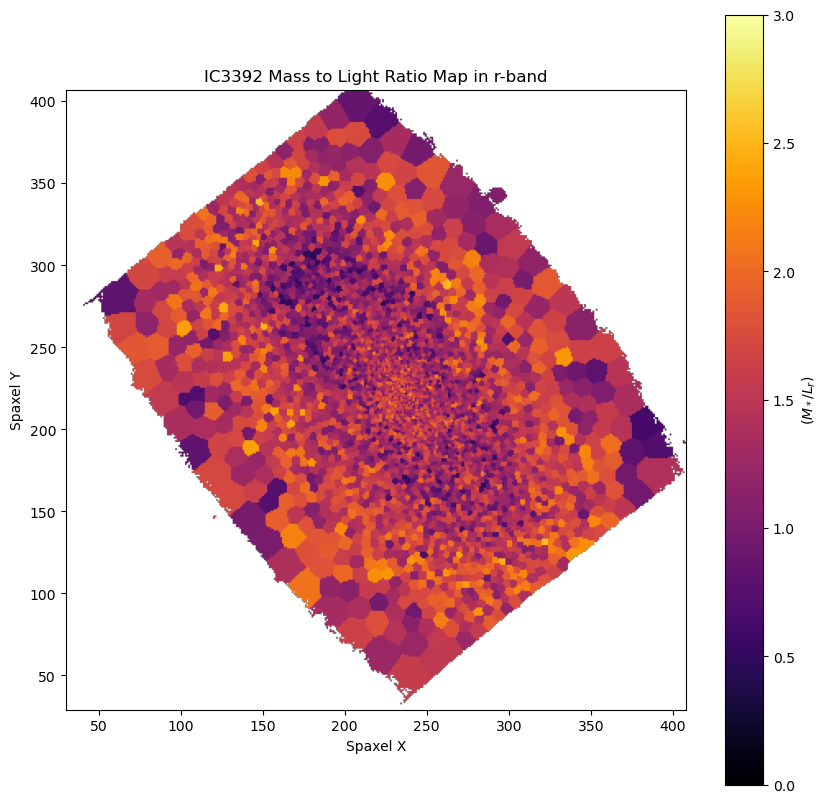

In [19]:
# # find bounding box of finite pixels
# nonnan = ~np.isnan(binning_MLR)
# ys, xs = np.where(nonnan)
# ymin, ymax = ys.min(), ys.max()
# xmin, xmax = xs.min(), xs.max()

# # compute half-widths of that box
# half_w = (xmax - xmin) // 2
# half_h = (ymax - ymin) // 2

# # integer center from previous fit
# cx_i, cy_i = binning_MLR.shape
# cx_i = cx_i // 2
# cy_i = cy_i // 2

# # build zoom window centered on (cx, cy)
# xmin_zoom = max(cx_i - half_w, 0)
# xmax_zoom = min(cx_i + half_w, binning_MLR.shape[1] - 1)
# ymin_zoom = max(cy_i - half_h, 0)
# ymax_zoom = min(cy_i + half_h, binning_MLR.shape[0] - 1)

# half_zoom = np.max(np.array([xmax_zoom-xmin_zoom, ymax_zoom-ymin_zoom])) // 2

# plt.figure(figsize=(10, 10))
# im = plt.imshow(binning_MLR, origin='lower', cmap='inferno', vmin=0, vmax=3)
# plt.colorbar(im, label=r'$\log_{10}(M_*/M_{\odot})$')

# plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
# plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# # plt.axis('equal')               # force equal scaling on x and y

# plt.title(f"IC3392 Stellar Mass Map")
# plt.xlabel("Pixel X")
# plt.ylabel("Pixel Y")
# plt.show()

# Plot the mass to light ratio map in r-band
plt.figure(figsize=(10, 10))
plt.imshow(binning_MLR, origin='lower', cmap='inferno', vmin=0, vmax=3)
cbar = plt.colorbar(label=r'$(M_*/L_r)$')
plt.title(f"IC3392 Mass to Light Ratio Map in r-band")
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

In [20]:
# Flux weighted M/L_R
np.nansum(binning_FLUX*binning_MLR)/np.nansum(binning_FLUX), np.log10(np.nansum(binning_FLUX*binning_MLR)/np.nansum(binning_FLUX))


(np.float64(1.4416080066671668), np.float64(0.1588471857060981))

In [21]:
# # -----------------------------------------------------------------
# # INPUT ARRAYS (438, 437) :
# #   binning_FLUX   erg s^-1 cm^-2 Å^-1  (10^-20 factor still present)
# #   binning_MLR    M☉ / L☉_R
# # DISTANCE:
# D = 16.5 * u.Mpc
# lam_r = 6231 * u.AA

# # 1) flux density F_λ  →  F_ν
# F_lambda = binning_FLUX * 1e-20 * u.erg / u.s / u.cm**2 / u.AA
# F_nu     = (F_lambda * lam_r**2 / c.c).to(u.erg / u.s / u.cm**2 / u.Hz)

# # 2) apparent AB magnitude per spaxel
# F_nu0 = (3631 * u.Jy).to(F_nu.unit)
# m_r   = -2.5 * np.log10( (F_nu / F_nu0).value )

# # 3) absolute magnitude & solar-unit luminosity
# M_r   = m_r - 5*np.log10( (D.to(u.pc).value)/10 )
# M_sun = 4.64                       # AB mag of the Sun in r
# L_Lsun = 10**(-0.4 * (M_r - M_sun))   # dimensionless L/L☉_r

# # 4) stellar mass map & its log10
# M_star = L_Lsun * binning_MLR          # M☉ per spaxel
# logM_star = np.log10(M_star, where=(M_star>0))  # keep NaN where flux=0

# # logM_star now holds log10(M*/M☉) for every valid spaxel


In [22]:
# # ---------------------------------------------------------------------
# # 0.  File paths
# # ---------------------------------------------------------------------
# cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
# vor_path  = Path("IC3392_SPATIAL_BINNING_maps.fits")
# sfh_path  = Path("IC3392_SFH_maps.fits")

# # ---------------------------------------------------------------------
# # 1.  r flux-density map per spaxel
# # ---------------------------------------------------------------------
# cube = fits.open(cube_path, memmap=True)
# data = cube["DATA"].data.astype(np.float32)          # (nz, ny, nx)
# hdr  = cube["DATA"].header
# nz, ny, nx = data.shape

# # wavelength grid (native header unit → Å)  --------  FIX #1
# spec_wcs   = WCS(hdr).sub(["spectral"])              # 1-axis WCS
# wave_native = spec_wcs.all_pix2world(
#                  np.arange(nz)[:, None], 0)[:, 0]    # numeric values
# wave = (wave_native * spec_wcs.wcs.cunit[0]).to(u.AA)   # use cunit[0]

# # r throughput
# rfilter = sp.load_filters("bessell-R")[0]
# T_full  = rfilter(wave)                # ndarray, shape (nz,)
# band    = T_full > 0
# wave    = wave[band]
# T       = T_full[band]                 # plain floats

# # ---------- integrand (corrected) -----------------------------------
# dlam      = np.gradient(wave.value) * u.AA
# F_lambda  = data[band] * 1e-20 * u.erg/u.s/u.cm**2/u.AA
# lam_cm    = wave.to(u.cm)

# # AA2CM  = 1e8                                             # Å → cm
# F_nu_i = F_lambda * (wave[:, None, None]**2 / c.c)
# weights = T * dlam
# num = np.sum(F_nu_i * weights[:, None, None], axis=0)
# den = weights.sum()
# F_nu = num / den
#         # (ny, nx)

# cube.close()

# # ---------------------------------------------------------------------
# # 2.  Collapse to Voronoi bins
# # ---------------------------------------------------------------------
# with fits.open(vor_path) as hd_v:
#     BINID      = hd_v["BINID"].data.astype(int)
#     muse_hdr2  = hd_v["BINID"].header
#     nan_mask   = ~np.isfinite(hd_v["FLUX"].data)
#     # binning_MLR = fits.getdata(
#     #     "IC3392_SPATIAL_BINNING_maps_extended.fits", "ML_R")

# uniq      = np.unique(BINID[BINID >= 0])
# flux      = F_nu.value.astype(np.float32)
# npix_bin  = sum_labels(np.ones_like(flux), BINID, uniq)
# mean_flux = sum_labels(flux, BINID, uniq) / npix_bin

# lut = np.full(int(BINID.max()) + 1, np.nan, dtype=np.float32)
# lut[uniq] = mean_flux
# FLUX_R = lut[BINID]                                    # (ny, nx)

# # ---------------------------------------------------------------------
# # 3.  Galactic-extinction correction
# # ---------------------------------------------------------------------
# EBV   = fits.getdata(sfh_path, "EBV").astype(np.float32)
# A_r   = 2.285 * EBV  # RV = 3.1 from Schlafly & Finkbeiner 2011, ApJ, 737, 103, or 2.165 from legacy survey
# FLUX_R_corr = FLUX_R * 10**(0.4 * A_r) * F_nu.unit
# FLUX_R_corr[nan_mask] = np.nan

# # ---------------------------------------------------------------------
# # 4.  Luminosity → stellar-mass map
# # ---------------------------------------------------------------------
# F0      = (3631 * u.Jy).to(FLUX_R_corr.unit)
# m_r     = -2.5 * np.log10((FLUX_R_corr / F0).value)
# distmod = 5 * np.log10((16.5 * u.Mpc).to(u.pc).value / 10)
# M_r     = m_r - distmod
# L_Lsun  = 10**(-0.4 * (M_r - 4.64))
# M_star  = L_Lsun * binning_MLR
# logM_star = np.where(M_star > 0, np.log10(M_star), np.nan)
# logM_star[nan_mask] = np.nan

In [23]:
# ---------------------------------------------------------------------
# 0.  File paths
# ---------------------------------------------------------------------
cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
vor_path  = Path("IC3392_SPATIAL_BINNING_maps.fits")
sfh_path  = Path("IC3392_SFH_maps.fits")

# # 1. Read cube & wavelength grid (unchanged) -------------------------------
# cube = fits.open(cube_path, memmap=False)
# data = cube["DATA"].data.astype(np.float32)         # (nz, ny, nx)
# hdr  = cube["DATA"].header
# nz, ny, nx = data.shape

# spec_wcs   = WCS(hdr).sub(['spectral'])
# wave = (spec_wcs.all_pix2world(np.arange(nz)[:, None], 0)[:, 0] *
#         spec_wcs.wcs.cunit[0]).to(u.AA)             # → (nz,) Quantity

# # 2. Attach proper flux units ---------------------------------------------
# F_lambda = data * (1e-20 * u.erg / (u.s * u.cm**2 * u.AA))

# # 3. Load SDSS *r* filter --------------------------------------------------
# f_r = filters.load_filter('bessell-r')           # or 'bessell-r' 

# # 4. Reshape to (ny, nx, nz) so last axis = wavelength --------------------
# flux_cube = F_lambda.transpose(1, 2, 0)             # (ny, nx, nz)

# # 5. Compute AB magnitudes -------------------------------------------------
# m_r = f_r.get_ab_magnitude(flux_cube, wave, axis=-1)   # (ny, nx) Quantity
# m_r_map = np.asarray(m_r, dtype=np.float32)         # strip units if desired

# ---------------------------------------------------------------------
# 1.  R-band magnitude map per spaxel using speclite
# ---------------------------------------------------------------------
cube = fits.open(cube_path, memmap=False)
data = cube["DATA"].data.astype(np.float32)          # (nz, ny, nx)
hdr  = cube["DATA"].header
nz, ny, nx = data.shape

# wavelength grid (native header unit → Å)
spec_wcs   = WCS(hdr).sub(["spectral"])              # 1-axis WCS
wave_native = spec_wcs.all_pix2world(
                 np.arange(nz)[:, None], 0)[:, 0]    # numeric values
wave = (wave_native * spec_wcs.wcs.cunit[0]).to(u.AA)   # use cunit[0]

# Load filter using speclite (more robust than synphot for this purpose)
f_r = filters.load_filter('bessell-R')  
# decamDR1noatm-r, bessell-R or 'sdss2010noatm-r'/'sdss2010-r' for SDSS r-band

# Convert flux units: MUSE cube is in 1e-20 erg s⁻¹ cm⁻² Å⁻¹
F_lambda = data * (1e-20 * u.erg / (u.s * u.cm**2 * u.AA))  # Add units 

# Calculate AB magnitude for each spaxel
ny, nx = data.shape[1], data.shape[2]
m_r_map = np.full((ny, nx), np.nan, dtype=np.float32)
maggies = np.full((ny, nx), np.nan, dtype=np.float32)

print("Computing AB magnitudes for each spaxel...")
for j in range(ny):
    if j % 50 == 0:  # Progress indicator
        print(f"Processing row {j}/{ny}")
    for i in range(nx):
        # Extract spectrum for this spaxel
        spectrum = F_lambda[:, j, i]
        m_r_map[j, i] = f_r.get_ab_magnitude(spectrum, wavelength=wave)
        maggies[j, i] = f_r.get_ab_maggies(spectrum, wavelength=wave)
# #-------------------------------------------------------------------------------------------
# # F0 = 3.631e-20 * u.erg / (u.s * u.cm**2 * u.Hz)   # AB zeropoint

# # # --- pre-compute filter response on the cube’s wavelength grid -------------
# # resp = f_r(wave)                          # same shape as wave
# # den  = np.trapz(resp / wave, wave)        # denominator stays constant

# # # --- inside the double loop -------------------------------------------------
# # for j in range(ny):
# #     if j % 50 == 0:
# #         print(f"Processing row {j}/{ny}")
# #     for i in range(nx):
# #         f_lambda = F_lambda[:, j, i]            # spectrum with units
# #         if np.any(f_lambda <= 0) or np.any(~np.isfinite(f_lambda)):
# #             m_r_map[j, i] = np.nan
# #             continue

# #         # λ→ν conversion : f_ν  = f_λ λ² / c
# #         f_nu = f_lambda * (wave**2 / c.c)

# #         num = np.trapz(f_nu * resp / wave, wave)   # numerator
# #         fnu_eff = num / den                        # band-averaged f_ν

# #         m_r_map[j, i] = -2.5 * np.log10((fnu_eff / F0).value)  # AB mag

cube.close()

# ---------------------------------------------------------------------
# 2.  Collapse to Voronoi bins
# ---------------------------------------------------------------------
with fits.open(vor_path) as hd_v:
    # ---------- PATCH BEGIN ----------
    # keep BINID as float so NaNs survive the read
    BINID_f32 = hd_v["BINID"].data.astype(np.float32)
    muse_hdr2 = hd_v["BINID"].header
    nan_mask  = ~np.isfinite(hd_v["FLUX"].data)

    # build an *integer* copy with sentinel -1 for “no bin”
    bad_pix = (~np.isfinite(BINID_f32)) | (BINID_f32 < 0)
    BINID   = BINID_f32.astype(np.int32)   # safe: all finite →
    BINID[bad_pix] = -1                   # mark blanks with −1
    # ---------- PATCH END ----------

# Handle negative BINID values (masked pixels)      ← DELETE this line
# BINID[BINID < 0] = np.nan                        ← (no longer needed)

uniq = np.unique(BINID[BINID >= 0])                 # keep this line

# Convert magnitude map to flux for averaging
F0_ref = 3631e-23  # Reference flux in erg s⁻¹ cm⁻² Hz⁻¹ for AB magnitude zero point
flux_map = F0_ref * 10**(-0.4 * m_r_map)  # Convert mag to flux
flux_map[nan_mask] = np.nan  # Keep NaNs where needed

# Average flux in each bin (excluding NaN pixels)
flux_map_clean = np.where(nan_mask | ~np.isfinite(m_r_map), np.nan, flux_map)
valid_pixels = sum_labels(~np.isnan(flux_map_clean), BINID, uniq)
sum_flux = sum_labels(np.nan_to_num(flux_map_clean), BINID, uniq)
mean_flux = np.divide(sum_flux, valid_pixels, 
                     out=np.full_like(sum_flux, np.nan), 
                     where=valid_pixels > 0)

# Convert back to magnitudes
mean_mag = -2.5 * np.log10(mean_flux / F0_ref)

# Create lookup table for bin-averaged magnitudes
lut = np.full(int(BINID.max()) + 1, np.nan, dtype=np.float32)
lut[uniq] = mean_mag
m_r_binned = lut[BINID]                                    # (ny, nx)
m_r_binned[nan_mask] = np.nan  # Keep NaNs where needed
flux_map_binned = F0_ref * 10**(-0.4 * m_r_binned)  # Convert mag to flux

# ---------------------------------------------------------------------
# 3.  Galactic-extinction correction
# ---------------------------------------------------------------------
EBV = fits.getdata(sfh_path, "EBV").astype(np.float32)

# Choose extinction coefficient based on your filter choice:
if 'bessell' in f_r.name.lower():
    A_r = 2.32 * EBV  # Bessell R-band coefficient (Fitzpatrick 1999)
    M_r_sun = 4.64    # Solar absolute magnitude in Bessell R
elif 'sdss' in f_r.name.lower():
    A_r = 2.285 * EBV  # SDSS r-band coefficient (Schlafly & Finkbeiner 2011)
    M_r_sun = 4.64     # Solar absolute magnitude in SDSS r
else:
    print(f"Warning: Unknown filter {f_r.name}, using SDSS coefficients")
    A_r = 2.285 * EBV
    M_r_sun = 4.64

# Apply extinction correction to magnitudes (subtract extinction)
m_r_corr = m_r_binned - A_r  # Magnitude correction
m_r_corr[nan_mask] = np.nan

# magnitude back to nanomaggies in Legacy survey format
def magnitude_to_nanomaggies(magnitude):
    return 10**((22.5 - magnitude) / 2.5)
FLUX_R_corr = magnitude_to_nanomaggies(m_r_corr)  # Convert to flux

# ---------------------------------------------------------------------
# 4.  Luminosity → stellar-mass map
# ---------------------------------------------------------------------
# Distance modulus for 16.5 Mpc
distmod = 5 * np.log10((16.5 * u.Mpc).to(u.pc).value / 10)

# Absolute magnitude
M_r = m_r_corr - distmod

# Luminosity in solar units
L_Lsun = 10**(-0.4 * (M_r - M_r_sun))

# Stellar mass (uncomment when binning_MLR is available)
M_star = L_Lsun * binning_MLR
logM_star = np.where(M_star > 0, np.log10(M_star), np.nan)
logM_star[nan_mask] = np.nan

print("R-band magnitude calculation completed!")
print(f"Filter used: {f_r.name}")
print(f"Magnitude range: {np.nanmin(m_r_corr):.2f} to {np.nanmax(m_r_corr):.2f}")
print(f"Distance modulus: {distmod:.2f} mag")

Computing AB magnitudes for each spaxel...
Processing row 0/438
Processing row 50/438
Processing row 100/438
Processing row 150/438
Processing row 200/438
Processing row 250/438
Processing row 300/438
Processing row 350/438
Processing row 400/438
R-band magnitude calculation completed!
Filter used: bessell-R
Magnitude range: 21.12 to 26.07
Distance modulus: 31.09 mag


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_18140/2230326096.py:105: RuntimeWarning: invalid value encountered in cast
  BINID   = BINID_f32.astype(np.int32)   # safe: all finite →


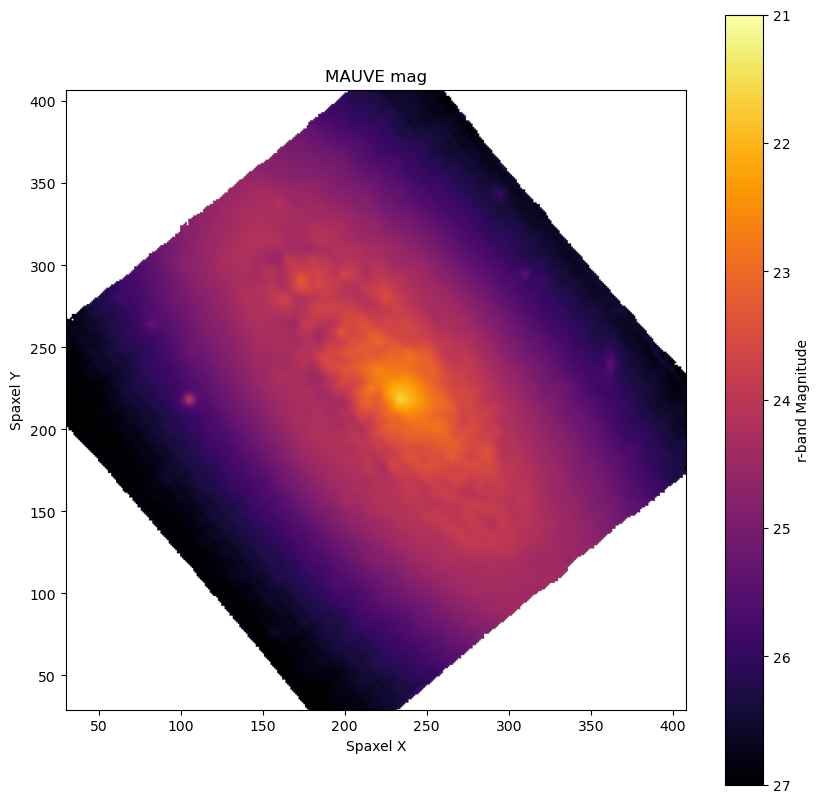

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(m_r_map, cmap='inferno_r', origin='lower', vmin=21, vmax=27)
plt.colorbar(label='r-band Magnitude').ax.invert_yaxis()
plt.title('MAUVE mag')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

In [25]:
# import importlib.resources as imp_res
# from mpdaf.obj import Cube, filters
# from astropy.io import fits
# import astropy.units as u
# import numpy as np

# # --- 1.  read Cousins-R throughput ---------------------------
# flt_path = imp_res.files(filters) / 'filter_list.fits'        # always present 
# with fits.open(flt_path) as hdul:
#     dat  = hdul['Cousins_R'].data
#     lam  = (dat['lambda'] * u.AA)
#     thr  = dat['throughput']

# # pivot wavelength λ_p                                         (standard definition) 
# λ_p = np.sqrt(np.trapezoid(thr, lam) / np.trapezoid(thr/lam**2, lam))
# print(f"Pivot wavelength λ_p = {λ_p:.2f}")

# # --- 2.  integrated-flux image from the cube -----------------
# cube  = Cube("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
# img_R = cube.get_band_image('Cousins_R')                      # erg s-1 cm-2 Å-1 per pixel 

# # --- 3.  Fλ [erg s-1 cm-2 Å-1]  ->  Fν  ----------------------
# Fλ = img_R.data * img_R.unit                                  # Quantity
# Fν = Fλ.to(u.Jy, equivalencies=u.spectral_density(λ_p))       # Jy per pixel 

# # --- 4.  AB magnitude map ------------------------------------
# m_AB = (-2.5 * np.log10(Fν / (3631*u.Jy))).value.astype('f4') # AB zeropoint 

# # set non-finite pixels to NaN
# m_AB[~np.isfinite(m_AB)] = np.nan

# # print total magnitude in R-band
# print(f"Total magnitude in R-band: {(-2.5 * np.log10(np.nansum(Fν) / (3631*u.Jy))).value.astype('f4'):.2f} AB mag")

# plt.figure(figsize=(10, 10))
# plt.imshow(m_AB, cmap='inferno_r', origin='lower', vmin=21, vmax=27)
# plt.colorbar(label='AB Magnitude').ax.invert_yaxis()
# plt.title('MAUVE mag')
# plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
# plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.xlabel("Spaxel X")
# plt.ylabel("Spaxel Y")
# plt.show()

In [26]:
# plt.figure(figsize=(10, 10))
# plt.imshow(maggies*1e9, cmap='inferno', origin='lower', vmin=0, vmax=3)
# plt.title('MAUVE unbinned flux')
# plt.colorbar()
# plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
# plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.xlabel("Spaxel X")
# plt.ylabel("Spaxel Y")
# plt.show()

In [27]:
# from synphot import SpectralElement, SourceSpectrum, Observation, Empirical1D
# from synphot import exceptions as synexc

# bp_r = SpectralElement.from_filter('cousins_r')       # or 'sdss2010-r'
# flux_cube = (data * 1e-20 *
#              u.erg / (u.s * u.cm**2 * u.AA)).reshape(nz, ny * nx)

# # Mask that remembers which spectra originally contained any NaN/Inf
# bad_spec = ~np.all(np.isfinite(flux_cube.value), axis=0)

# mags = np.full(ny * nx, np.nan, dtype=np.float32)      # start all-NaN

# for i in range(ny * nx):
#     fl = flux_cube[:, i]

#     # Replace NaNs with zero only for the convolution
#     fl_no_nan = np.nan_to_num(fl, nan=0.0)

#     try:
#         sp  = SourceSpectrum(Empirical1D, points=wave, lookup_table=fl_no_nan)
#         obs = Observation(sp, bp_r, force='taper')
#         mags[i] = obs.effstim('abmag').value
#     except synexc.SynphotError:
#         # catches spectra that integrate to ≤0 (all zero, all negative, etc.)
#         pass                                           # leave as NaN

# # Re-flag any spaxel that *originally* had a NaN anywhere in its spectrum
# mags[bad_spec] = np.nan
# m_r_map = mags.reshape(ny, nx)


In [28]:
# # 0) Imports, filter, wavelength grid (unchanged) --------------------------
# import numpy as np, astropy.units as u, tempfile, os, joblib, time
# from joblib import Parallel, delayed
# from tqdm.auto import tqdm
# from synphot import (SpectralElement, SourceSpectrum,
#                      Observation, Empirical1D, exceptions as synexc)
                     

# bp_r   = SpectralElement.from_filter('cousins_r')        # CDBS filter:contentReference[oaicite:3]{index=3}
# wave_q = wave                                             # Quantity (nz,)

# # 1) Flatten cube → mem-map (unchanged) ------------------------------------
# flux_val = (data.astype(np.float32) * 1e-20).reshape(nz, ny * nx)   # FLAM

# tmpfile = tempfile.NamedTemporaryFile(suffix='.mmap', delete=False).name
# joblib.dump(flux_val, tmpfile)                                   # write once
# flux_mm = joblib.load(tmpfile, mmap_mode='r')                    # shared RO

# # 2) Worker ---------------------------------------------------------------
# def abmag_for_idx(idx):
#     """AB mag for one spaxel (NaN if integrated flux ≤ 0)."""
#     # Re-attach units and zero-fill NaNs only for computation
#     fl = np.nan_to_num(flux_mm[:, idx], nan=0.0) * (
#           u.erg / (u.s * u.cm**2 * u.AA))

#     try:
#         sp  = SourceSpectrum(Empirical1D, points=wave_q, lookup_table=fl)
#         obs = Observation(sp, bp_r, force='taper')                # taper edges:contentReference[oaicite:4]{index=4}
#         mag = obs.effstim('abmag').value                          # AB mag calc:contentReference[oaicite:5]{index=5}:contentReference[oaicite:6]{index=6}
#         return mag  # keeps negative mags if very bright
#     except synexc.SynphotError:
#         return np.nan                                             # flux ≤ 0, etc.

# # 3) Launch parallel pool --------------------------------------------------
# def main():
#     n_jobs = min(10, os.cpu_count())            
#     total  = ny * nx
#     t0 = time.time()
#     result = Parallel(n_jobs=n_jobs,
#                       backend='loky',    # robust cross-platform backend:contentReference[oaicite:7]{index=7}
#                       batch_size=2048,   # time per batch ≳ 0.5 s
#                       verbose=5)(
#                  delayed(abmag_for_idx)(i) for i in tqdm(range(total),
#                                                 total=total,
#                                                 desc='R-band mags',
#                                                 unit='spx'))
#     print(f"Wall-time: {time.time() - t0:5.2f} s")

#     m_r_map = np.asarray(result, dtype=np.float32).reshape(ny, nx)
#     good    = np.isfinite(m_r_map)
#     print(f"{good.sum()} of {ny*nx} spaxels have valid AB magnitudes "
#           f"({good.mean()*100:4.1f} %).")
#     print(f"\nFinished: {good.sum():,} / {total:,} "
#           f"({good.mean()*100:4.1f} %) valid magnitudes")
#     print(f"Range: {np.nanmin(m_r_map):.2f} ≤ m_r ≤ {np.nanmax(m_r_map):.2f}")
#     # --- FITS append (optional) ---
#     # from astropy.io import fits
#     # hdu = fits.ImageHDU(m_r_map, name='Cousins_r_ABMAG')
#     # hdu.header['BUNIT'] = 'mag(AB)'
#     # with fits.open(cube_path, mode='update') as hdul:
#     #     hdul.append(hdu); hdul.flush()

# if __name__ == '__main__':      # required by macOS spawn model:contentReference[oaicite:9]{index=9}
#     main()


In [29]:
np.nanmax(m_r_map)

np.float32(28.511175)

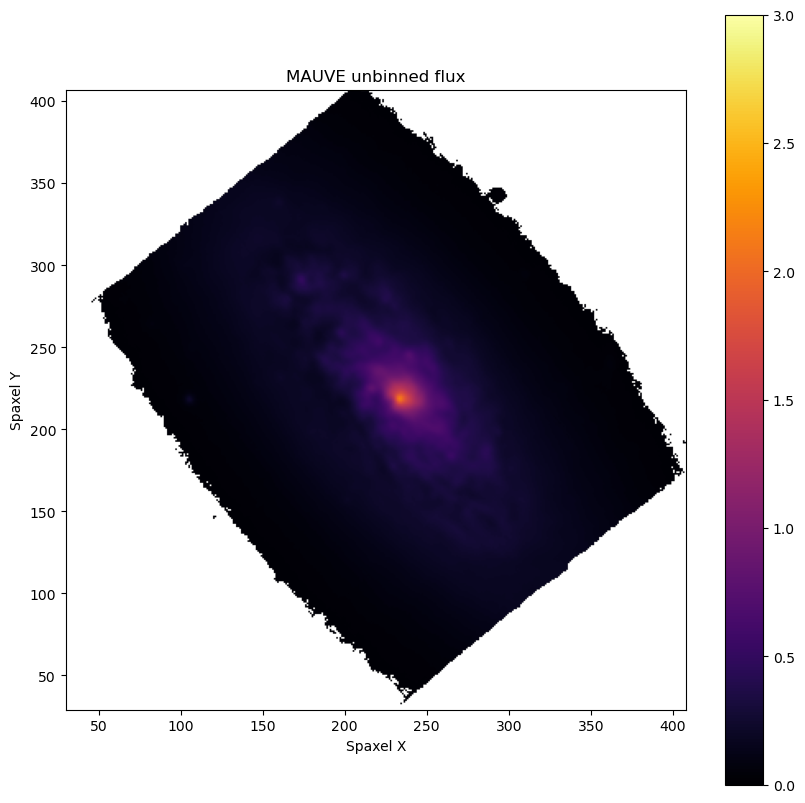

In [30]:
def magnitude_to_nanomaggies(magnitude):
    return 10**((22.5 - magnitude) / 2.5)
nanomaggies_map = magnitude_to_nanomaggies(m_r_map)
nanomaggies_map[nan_mask] = np.nan  # Keep NaNs where needed

plt.figure(figsize=(10, 10))
plt.imshow(nanomaggies_map, cmap='inferno', origin='lower', vmin=0, vmax=3)
plt.title('MAUVE unbinned flux')
plt.colorbar()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

In [31]:
np.nanmax(nanomaggies_map), np.nanmin(nanomaggies_map), np.nansum(nanomaggies_map)

(np.float32(2.1174247), np.float32(0.028090063), np.float32(11967.073))

In [32]:
22.5 - 2.5 * np.log10(np.nansum(nanomaggies_map))

np.float32(12.30503)

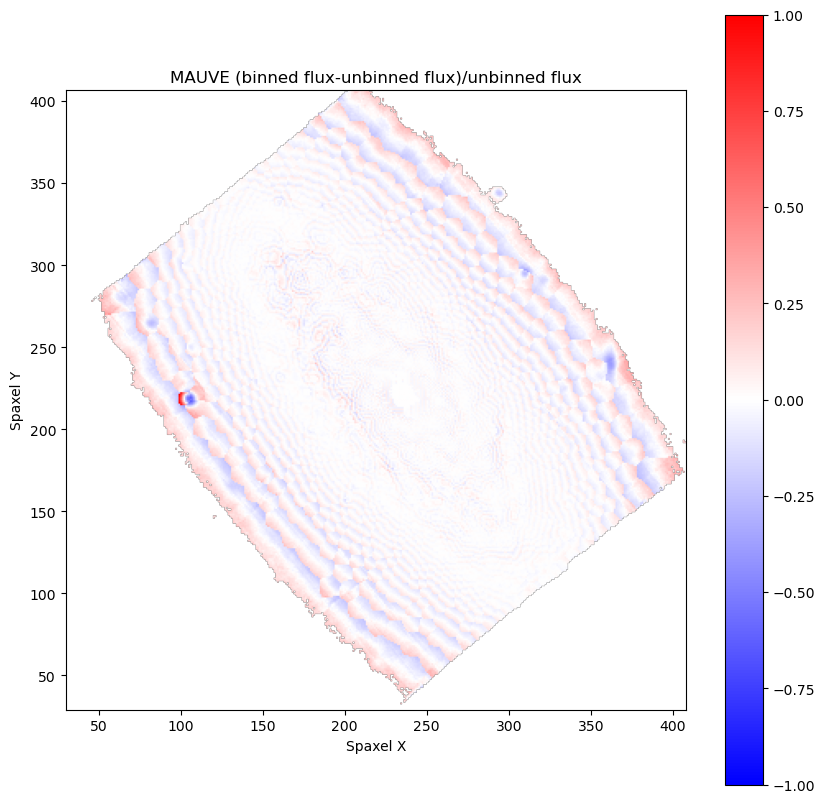

In [33]:
# Plot the (binned flux-unbinned flux)/unbinned flux
plt.figure(figsize=(10, 10))
plt.imshow((flux_map_binned-flux_map)/flux_map, cmap='bwr', origin='lower', vmin=-1, vmax=1)
plt.title('MAUVE (binned flux-unbinned flux)/unbinned flux')
plt.colorbar()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

In [34]:
# # ---------------------------------------------------------------------
# # 0.  File paths
# # ---------------------------------------------------------------------
# cube_path = Path("IC3392_DATACUBE_FINAL_WCS_Pall_mad_red_v3.fits")
# vor_path  = Path("IC3392_SPATIAL_BINNING_maps.fits")
# sfh_path  = Path("IC3392_SFH_maps.fits")

# # ---------------------------------------------------------------------
# # 1.  R-band magnitude map per spaxel using synphot
# # ---------------------------------------------------------------------
# cube = fits.open(cube_path, memmap=True)
# data = cube["DATA"].data.astype(np.float32)          # (nz, ny, nx)
# hdr  = cube["DATA"].header
# nz, ny, nx = data.shape

# # wavelength grid (native header unit → Å)
# spec_wcs   = WCS(hdr).sub(["spectral"])              # 1-axis WCS
# wave_native = spec_wcs.all_pix2world(
#                  np.arange(nz)[:, None], 0)[:, 0]    # numeric values
# wave = (wave_native * spec_wcs.wcs.cunit[0]).to(u.AA)   # use cunit[0]

# # Load filter using synphot instead of speclite
# import synphot as syn
# try:
#     # Try standard filter names first
#     bp = syn.SpectralElement.from_filter('bessell_r')
# except:
#     try:
#         # Alternative: try with different naming convention
#         bp = syn.SpectralElement.from_filter('cousins_r')
#     except:
#         # If standard filters don't work, load from file or define manually
#         # This is a fallback - you may need to adjust the filter name
#         print("Warning: Using generic R filter. Consider loading specific filter file.")
#         # You can load from file: bp = syn.SpectralElement.from_file('your_filter.dat')
#         # For now, create a simple Gaussian approximation for R-band
#         r_center = 6500 * u.AA  # R-band center
#         r_width = 1000 * u.AA   # R-band width
#         wave_filter = np.linspace(5000, 8000, 1000) * u.AA
#         trans_filter = np.exp(-0.5 * ((wave_filter - r_center) / (r_width/2.355))**2)
#         bp = syn.SpectralElement(syn.Empirical1D, points=wave_filter, lookup_table=trans_filter)

# # Convert flux units: MUSE cube is typically in 1e-20 erg s⁻¹ cm⁻² Å⁻¹
# F_lambda = data * (1e-20 * u.erg / (u.s * u.cm**2 * u.AA))  # Add units properly

# # Calculate AB magnitude for each spaxel
# # This is more memory-efficient than computing all at once for large cubes
# ny, nx = data.shape[1], data.shape[2]
# m_r_map = np.full((ny, nx), np.nan, dtype=np.float32)

# print("Computing AB magnitudes for each spaxel using synphot...")
# for j in range(ny):
#     if j % 50 == 0:  # Progress indicator
#         print(f"Processing row {j}/{ny}")
#     for i in range(nx):
#         # Extract spectrum for this spaxel
#         spectrum = F_lambda[:, j, i]
        
#         # Skip if spectrum is all NaN or has too many bad values
#         valid_mask = np.isfinite(spectrum)
#         # if np.sum(valid_mask) < len(spectrum) * 0.5:  # Need at least 50% valid data
#         #     continue
            
#         try:
#             # Create synphot spectrum object
#             spec = syn.SourceSpectrum(syn.Empirical1D, 
#                                     points=wave, 
#                                     lookup_table=spectrum)
            
#             # Create observation and calculate AB magnitude
#             obs = syn.Observation(spec, bp)
#             m_r_map[j, i] = obs.effstim('abmag')
            
#         except:
#             # Handle any errors in magnitude calculation (e.g., nan flux)
#             m_r_map[j, i] = np.nan

# cube.close()

# # ---------------------------------------------------------------------
# # 2.  Collapse to Voronoi bins
# # ---------------------------------------------------------------------
# with fits.open(vor_path) as hd_v:
#     BINID      = hd_v["BINID"].data.astype(int)
#     muse_hdr2  = hd_v["BINID"].header
#     nan_mask   = ~np.isfinite(hd_v["FLUX"].data)

# # For magnitudes, we need to be careful about averaging
# # Convert magnitudes back to flux for proper averaging, then back to magnitudes
# uniq = np.unique(BINID[BINID >= 0])

# # Convert magnitude map to flux for averaging
# F0_ref = 3631e-23  # Reference flux in erg s⁻¹ cm⁻² Hz⁻¹ for AB magnitude zero point
# flux_map = F0_ref * 10**(-0.4 * m_r_map)  # Convert mag to flux

# # Average flux in each bin (excluding NaN pixels)
# flux_map_clean = np.where(nan_mask | ~np.isfinite(m_r_map), np.nan, flux_map)
# valid_pixels = sum_labels(~np.isnan(flux_map_clean), BINID, uniq)
# sum_flux = sum_labels(np.nan_to_num(flux_map_clean), BINID, uniq)
# mean_flux = np.divide(sum_flux, valid_pixels, 
#                      out=np.full_like(sum_flux, np.nan), 
#                      where=valid_pixels > 0)

# # Convert back to magnitudes
# mean_mag = -2.5 * np.log10(mean_flux / F0_ref)

# # Create lookup table for bin-averaged magnitudes
# lut = np.full(int(BINID.max()) + 1, np.nan, dtype=np.float32)
# lut[uniq] = mean_mag
# m_r_binned = lut[BINID]                                    # (ny, nx)
# m_r_binned[nan_mask] = np.nan  # Keep NaNs where needed

# # ---------------------------------------------------------------------
# # 3.  Galactic-extinction correction
# # ---------------------------------------------------------------------
# EBV = fits.getdata(sfh_path, "EBV").astype(np.float32)

# # Choose extinction coefficient based on your filter choice:
# # Since using synphot, we'll determine filter type from the bandpass object
# filter_name = str(bp).lower() if hasattr(bp, '__str__') else 'unknown'
# if 'bessell' in filter_name or 'johnson' in filter_name:
#     A_r = 2.32 * EBV  # Bessell/Johnson R-band coefficient (Fitzpatrick 1999)
#     M_r_sun = 4.41    # Solar absolute magnitude in Bessell R
# elif 'sdss' in filter_name:
#     A_r = 2.285 * EBV  # SDSS r-band coefficient (Schlafly & Finkbeiner 2011)
#     M_r_sun = 4.64     # Solar absolute magnitude in SDSS r
# else:
#     print(f"Warning: Unknown filter type, using Bessell coefficients")
#     A_r = 2.32 * EBV
#     M_r_sun = 4.41

# # Apply extinction correction to magnitudes (subtract extinction)
# m_r_corr = m_r_binned - A_r  # Magnitude correction
# m_r_corr[nan_mask] = np.nan

# # magnitude back to nanomaggies in Legacy survey format
# def magnitude_to_nanomaggies(magnitude):
#     return 10**((22.5 - magnitude) / 2.5)
# FLUX_R_corr = magnitude_to_nanomaggies(m_r_corr)  # Convert to flux

# # ---------------------------------------------------------------------
# # 4.  Luminosity → stellar-mass map
# # ---------------------------------------------------------------------
# # Distance modulus for 16.5 Mpc
# distmod = 5 * np.log10((16.5 * u.Mpc).to(u.pc).value / 10)

# # Absolute magnitude
# M_r = m_r_corr - distmod

# # Luminosity in solar units
# L_Lsun = 10**(-0.4 * (M_r - M_r_sun))

# # Stellar mass (uncomment when binning_MLR is available)
# M_star = L_Lsun * binning_MLR
# logM_star = np.where(M_star > 0, np.log10(M_star), np.nan)
# logM_star[nan_mask] = np.nan

# print("R-band magnitude calculation completed!")
# print(f"Filter used: synphot bandpass")
# print(f"Magnitude range: {np.nanmin(m_r_corr):.2f} to {np.nanmax(m_r_corr):.2f}")
# print(f"Distance modulus: {distmod:.2f} mag")

In [35]:
# -------------------------------------------------------------------------
# inputs already in memory:
#   binning_MLR  -> (438, 437) float32   (we’ll cast to float64 like others)
#   binning_path -> Path to original file ("IC3392_SPATIAL_BINNING_maps.fits")
# -------------------------------------------------------------------------

out_path = Path("IC3392_SPATIAL_BINNING_maps_extended.fits")

# 1) read the whole HDUList from disk
with fits.open(binning_path) as hdul:
    # 2) clone all existing HDUs into a new list
    new_hdul = fits.HDUList([hdu.copy() for hdu in hdul])

# 3) build the new FLUX_R_corr image HDU
FLUX_R_corr_hdu = fits.ImageHDU(
    data=FLUX_R_corr.astype(np.float64), name="FLUX_R_corr")

# 4) keep WCS and pixel-scale info by copying the original BINID header
FLUX_R_corr_hdu.header.update(binning_hdr)         # you created binning_hdr earlier
FLUX_R_corr_hdu.header["EXTNAME"] = "FLUX_R_corr"
FLUX_R_corr_hdu.header["BUNIT"]   = "erg/s/cm2/Hz"  # physical units

# 5) append and write to disk
new_hdul.append(FLUX_R_corr_hdu)
new_hdul.writeto(out_path, overwrite=True)

print(f"Saved extended file to {out_path.resolve()}")

Saved extended file to /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps_extended.fits


In [36]:
with fits.open(out_path, mode="append") as hdul:             # open existing file
    new_hdu = fits.ImageHDU(data=binning_MLR.astype(np.float64),  # like others
                             header=binning_hdr, name="ML_R")
    new_hdu.header["EXTNAME"] = "ML_R"                       # name keyword
    new_hdu.header["BUNIT"] = "Msol/Lsol_R"                   # units keyword
    hdul.append(new_hdu)                                    # add as 9-th HDU
    hdul.flush()                                             # write in-place

print("M/L_R layer saved ➜", out_path.resolve())

M/L_R layer saved ➜ /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps_extended.fits


In [37]:
# R-band magnitude
-2.5 * np.log10( np.nansum((flux_map / F0_ref)) )

np.float32(12.305031)

In [38]:
m_r_map

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(438, 437), dtype=float32)

In [39]:
# R-band total stellar mass
np.log10(np.nansum(M_star))

np.float64(9.639267366878425)

In [40]:
# R-band total luminosity
np.log10(np.nansum(L_Lsun))

np.float64(9.484748530105817)

In [41]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   logM_star      (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   binning_hdr    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    mass_hdu = fits.ImageHDU(data=logM_star.astype(np.float64),  # like others
                             header=binning_hdr, name="LOGMSTAR")
    mass_hdu.header["BUNIT"] = "log(Msol)"                   # units keyword
    hdul.append(mass_hdu)                                    # add as 9-th HDU
    hdul.flush()                                             # write in-place

print("Stellar-mass layer saved ➜", out_path.resolve())


Stellar-mass layer saved ➜ /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps_extended.fits


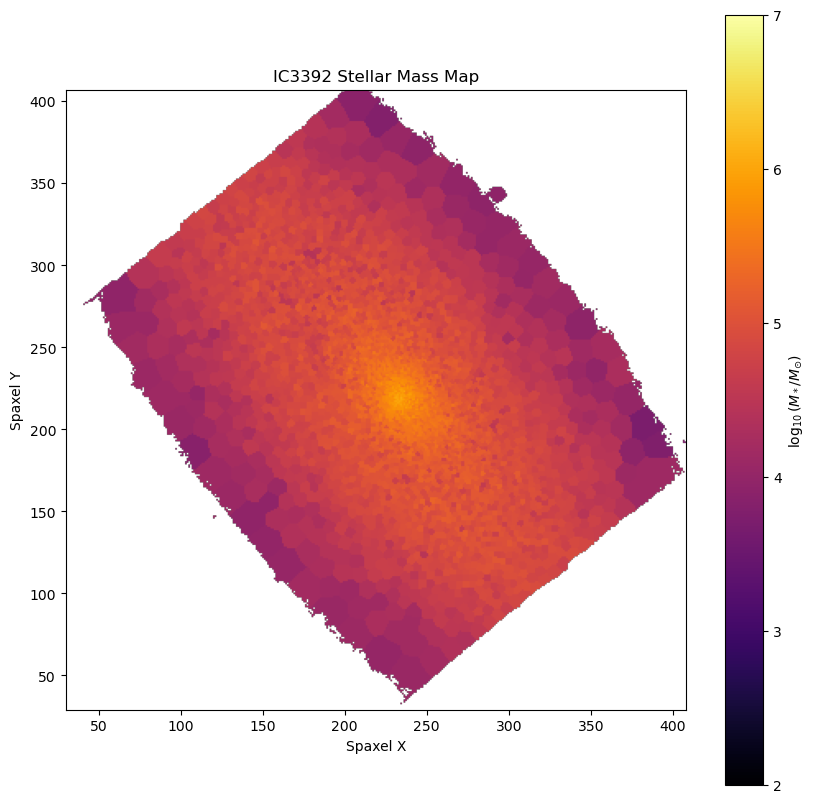

In [42]:
# find bounding box of finite pixels
nonnan = ~np.isnan(logM_star)
ys, xs = np.where(nonnan)
ymin, ymax = ys.min(), ys.max()
xmin, xmax = xs.min(), xs.max()

# compute half-widths of that box
half_w = (xmax - xmin) // 2
half_h = (ymax - ymin) // 2

# integer center from previous fit
cx_i, cy_i = logM_star.shape
cx_i = cx_i // 2
cy_i = cy_i // 2

# build zoom window centered on (cx, cy)
xmin_zoom = max(cx_i - half_w, 0)
xmax_zoom = min(cx_i + half_w, logM_star.shape[1] - 1)
ymin_zoom = max(cy_i - half_h, 0)
ymax_zoom = min(cy_i + half_h, logM_star.shape[0] - 1)

half_zoom = np.max(np.array([xmax_zoom-xmin_zoom, ymax_zoom-ymin_zoom])) // 2

plt.figure(figsize=(10, 10))
im = plt.imshow(logM_star, origin='lower', cmap='inferno', vmin=2, vmax=7)
plt.colorbar(im, label=r'$\log_{10}(M_*/M_{\odot})$')

plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 Stellar Mass Map")
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

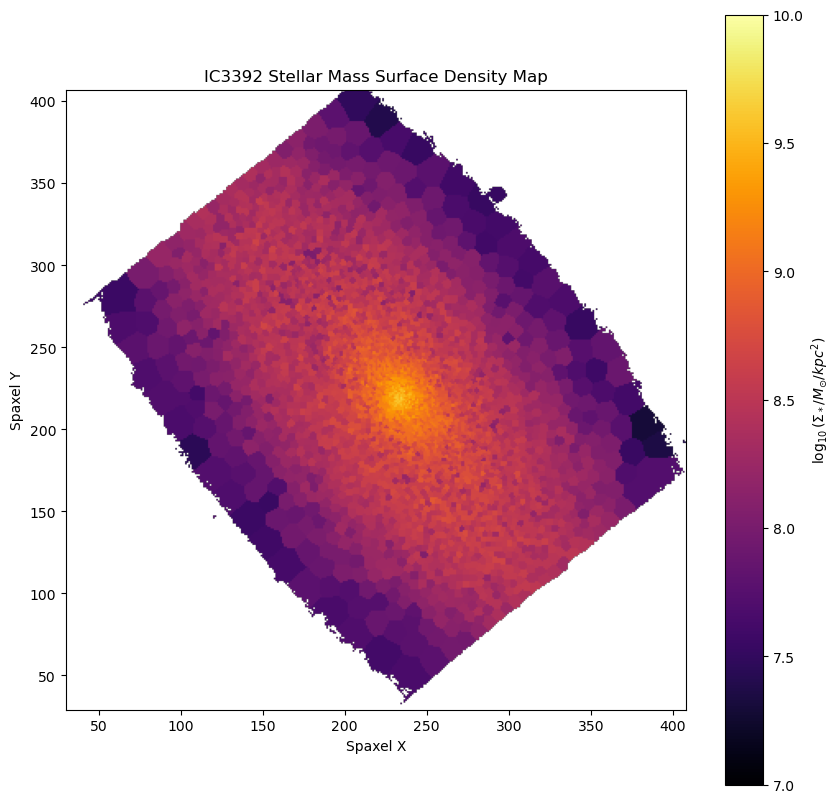

In [43]:
# Getting the stellar mass surface density 
# Convert to surface density in M☉/pc²
# 1. Convert pixel area to physical area in pc²
legacy_wcs2 = WCS(binning_hdr).celestial  # strip spectral axis
pixel_scale = (proj_plane_pixel_scales(legacy_wcs2) * u.deg).to(u.arcsec)
pixel_area_Mpc = ((pixel_scale[0]).to(u.rad).value*16.5*u.Mpc)*(((pixel_scale[1]).to(u.rad).value*16.5*u.Mpc))
pixel_area_kpc = pixel_area_Mpc.to(u.kpc**2)
# 2. Convert stellar mass to surface density
stellar_mass_surface_density = M_star / pixel_area_kpc  # M☉/kpc²
# 3. Convert to log10 scale
log_stellar_mass_surface_density = np.log10(stellar_mass_surface_density.value)

plt.figure(figsize=(10, 10))    
im = plt.imshow(log_stellar_mass_surface_density, origin='lower', 
                cmap='inferno', vmin=7, vmax=10)
plt.colorbar(im, label=r'$\log_{10}(\Sigma_*/M_{\odot}/kpc^2)$')
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
plt.title(f"IC3392 Stellar Mass Surface Density Map")
plt.xlabel("Spaxel X")
plt.ylabel("Spaxel Y")
plt.show()

In [44]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   logM_star      (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   binning_hdr    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    mass_density_hdu = fits.ImageHDU(
        data=log_stellar_mass_surface_density.astype(np.float64),  # like others
        header=binning_hdr, name="LOGMASS_SURFACE_DENSITY")
    mass_density_hdu.header["BUNIT"] = "log(Msol/kpc2)"  # units keyword
    hdul.append(mass_density_hdu)                                    # add as 10-th HDU 
    hdul.flush()                                             # write in-place
print("Stellar mass surface density layer saved ➜", out_path.resolve())

Stellar mass surface density layer saved ➜ /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps_extended.fits


In [45]:
np.nanmin(m_r_corr), np.nanmax(m_r_corr), np.nanmean(m_r_corr), np.nanstd(m_r_corr)

(np.float32(21.121609),
 np.float32(26.071795),
 np.float32(24.5952),
 np.float32(0.93578565))

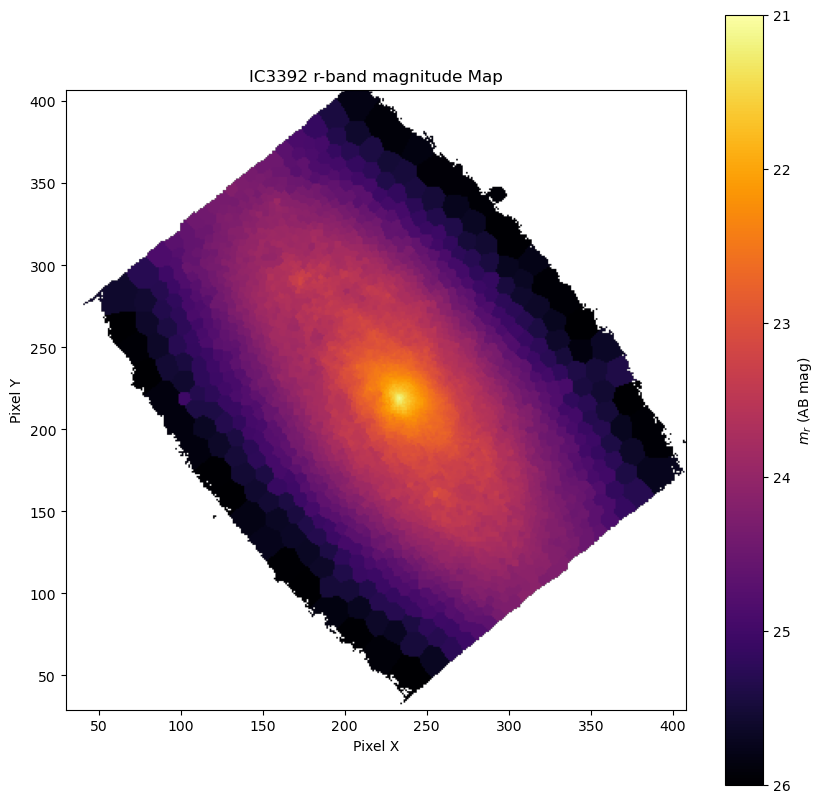

In [46]:
# # find bounding box of finite pixels
# nonnan = ~np.isnan(m_r_corr)
# ys, xs = np.where(nonnan)
# ymin, ymax = ys.min(), ys.max()
# xmin, xmax = xs.min(), xs.max()

# # compute half-widths of that box
# half_w = (xmax - xmin) // 2
# half_h = (ymax - ymin) // 2

# # integer center from previous fit
# cx_i, cy_i = m_r_corr.shape
# cx_i = cx_i // 2
# cy_i = cy_i // 2

# # build zoom window centered on (cx, cy)
# xmin_zoom = max(cx_i - half_w, 0)
# xmax_zoom = min(cx_i + half_w, m_r_corr.shape[1] - 1)
# ymin_zoom = max(cy_i - half_h, 0)
# ymax_zoom = min(cy_i + half_h, m_r_corr.shape[0] - 1)

# half_zoom = np.max(np.array([xmax_zoom-xmin_zoom, ymax_zoom-ymin_zoom])) // 2

plt.figure(figsize=(10, 10))
im = plt.imshow(m_r_corr, origin='lower', cmap='inferno_r', vmin=21, vmax=26)
plt.colorbar(im, label=r'$m_r$ (AB mag)').ax.invert_yaxis()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 r-band magnitude Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [47]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   m_R            (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   binning_hdr    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    m_r_hdu = fits.ImageHDU(data=m_r_corr.astype(np.float64),  # like others
                             header=binning_hdr, name="magnitude_r")
    m_r_hdu.header["BUNIT"] = "mag_AB"                   # units keyword
    hdul.append(m_r_hdu)                                    # add as 9-th HDU
    hdul.flush()                                             # write in-place

print("r-band magnitude layer saved ➜", out_path.resolve())

r-band magnitude layer saved ➜ /Users/Igniz/Desktop/ICRAR/data/IC3392/IC3392_SPATIAL_BINNING_maps_extended.fits


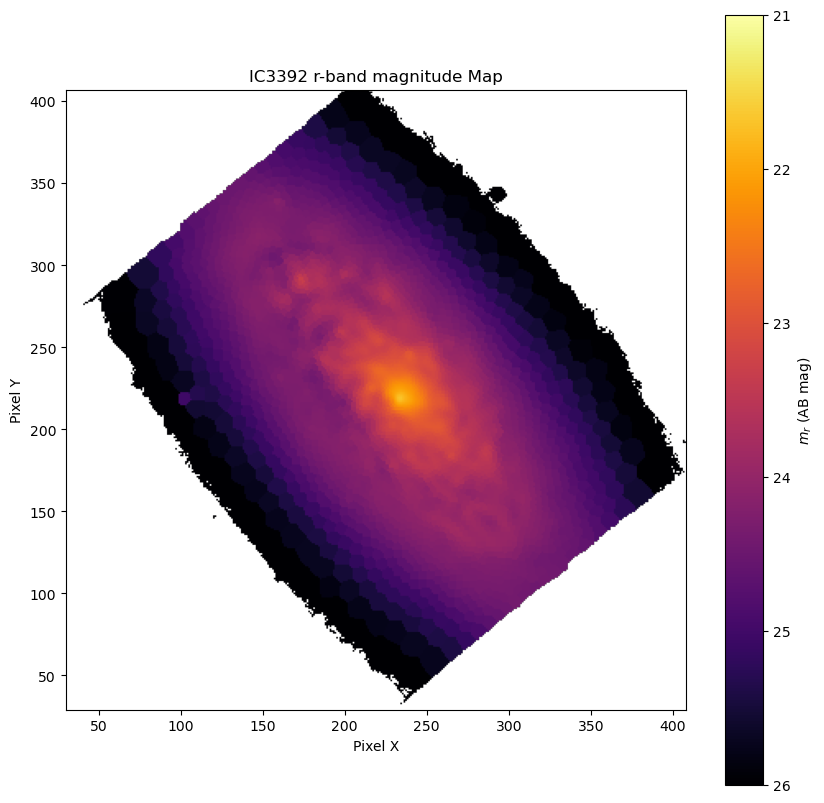

In [48]:
plt.figure(figsize=(10, 10))
im = plt.imshow(m_r_binned, origin='lower', cmap='inferno_r', vmin=21, vmax=26)
plt.colorbar(im, label=r'$m_r$ (AB mag)').ax.invert_yaxis()
plt.xlim(cx_i-half_zoom, cx_i+half_zoom)
plt.ylim(cy_i-half_zoom, cy_i+half_zoom)
# plt.axis('equal')               # force equal scaling on x and y

plt.title(f"IC3392 r-band magnitude Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.show()

In [49]:
# -----------------------------------------------------------------
# INPUTS already in memory
#   m_R            (438, 437)  float32   ← log10(M*/M☉) per spaxel
#   binning_hdr    WCS header you copied from the BINID image
#   out_path       Path("IC3392_SPATIAL_BINNING_maps_extended.fits")
# -----------------------------------------------------------------

with fits.open(out_path, mode="append") as hdul:             # open existing file
    m_r_uncorrected_hdu = fits.ImageHDU(data=m_r_binned.astype(np.float64),  # like others
                             header=binning_hdr, name="magnitude_r_uncorrected")
    m_r_uncorrected_hdu.header["BUNIT"] = "mag_AB"                   # units keyword
    hdul.append(m_r_uncorrected_hdu)                                    # add as 9-th HDU
    hdul.flush()                                             # write in-place
